# CNR annual financial analysis
Duncan Callaway

*Notebook originally created: April 14, 2019*

This notebook processes UCOP-provided financial data [(available here)](https://www.ucop.edu/financial-accounting/financial-reports/campus-financial-schedules/index.html) from a subset of UC campuses.  Focus is on UC Berkeley and its College of Natural resources.

How I got the data: Ruth Satorre (<Ruth.Satorre@ucop.edu>) and Alvin Thai (<Alvin.Thai@ucop.edu>) kindly sent me the data in xls format.  I then created the file "UCBanalysis.xlsx", which pulls data from each yearly file into one table that can be easily imported into a jupyter notebook.

In [2]:
import pandas as pd
import numpy as np
import os
os.system('cmd command')

import matplotlib.pyplot as plt
import seaborn as sns; #sns.set()

from matplotlib.ticker import MaxNLocator

First load the data and add a couple of columns.

In [3]:
UCBdata = pd.read_excel('UCB Schedule C FY14-18/UCBanalysis.xlsx')
# Create new column: total annual expenditure by unit, 
UCBdata.loc[:,'total'] = np.sum(UCBdata.loc[:,'unrestricted_general':'restricted'], axis = 1)
# scale so everything is in millions of dollars
UCBdata.loc[:,'unrestricted_general':'total'] = UCBdata.loc[:,'unrestricted_general':'total']/1e6

In [4]:
UCBdata.head()

,campus,unit,category,subcat,year,unrestricted_general,unrestricted_designated,restricted,salaries_wages,other_expend,transfers,total
0,UCB,AES,academic_support,0,2014,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,UCB,AES,instruction,0,2014,0.125,0.056,0.325,0.231,0.275,0.000,0.506
2,UCB,AES,research,0,2014,16.460,1.334,24.089,24.324,17.850,-0.291,41.883
3,UCB,AES,service,0,2014,0.000,0.000,0.005,0.000,0.005,0.000,0.005
4,UCB,CED,academic_support,0,2014,0.000,0.275,0.000,0.223,0.052,0.000,0.275


An important note about the "subcategory" column.  If the entry here is not zero, that means the row contains expenditures already captured within another larger category.  For example, total unit spending on research includes many subcategories, one of which is dean's office spending, i.e. the "research_dean" category.  

Let's see what units are represented:

In [5]:
UCBdata['unit'].unique()

array(['AES', 'CED', 'CNR', 'financialaid', 'InstSupport', 'SPH', 'SPP',
       'StudentServices', 'total'], dtype=object)

In the above, 

* AES = ag experiment station (housed within CNR)
* CED = college of environmental design
* CNR = college of natural resources
* financialaid = all undergraduate financial aid expenditures
* InstSupport = most central campus administrative costs.
* SPH = school of public health
* SPP = school of public policy

Next create some indexing vectors 
* One marking all CNR and AES entries
* Another marking instruction and research entries

In [6]:
idx_CNR_AES = (UCBdata.loc[:,'unit'] == 'AES') | (UCBdata.loc[:,'unit'] == 'CNR')
idx_InstRes = (UCBdata.loc[:,'category'] == 'research') | (UCBdata.loc[:,'category'] == 'instruction')

To get total spending for CNR and AES combined within each category, run a groupby

In [7]:
grouped_CNRAES_InstRes = UCBdata.loc[idx_CNR_AES&idx_InstRes,:]\
    .groupby(by = ['year','category'], as_index=False).sum()

Some detail that gets washed out in this grouping:
* Most research expenditures fall under AES.  
* The primary CNR research expenditures are Dean's office research exenditures and the plant gene experiment center.

### CNR teaching and research expenditures
Plot CNR teaching and research expenditures over last 5 years.

Note, there is also a "service" category, but spending there is extremeley small.  

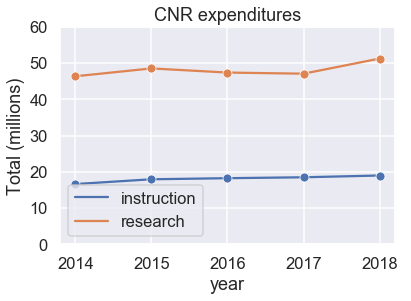

In [8]:
sns.set()
sns.set_context("talk")
ax = sns.lineplot(x = 'year',
             y = 'total',
             hue = 'category',
             marker = 'o',
             data = grouped_CNRAES_InstRes);
ax.set(ylabel='Total (millions)')
ax.set_title('CNR expenditures')
plt.ylim(0, 60)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.ticklabel_format(style='plain', axis='y')
# now do a backflip to get rid of the legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:]);

### Spending breakdown for CNR vs AES
The rough spending breakdown is that CNR handles teaching expenditures and AES handles research.  

As we'll see later, the key exception is Dean's office expenditures on research comes out of both AES and CNR.  

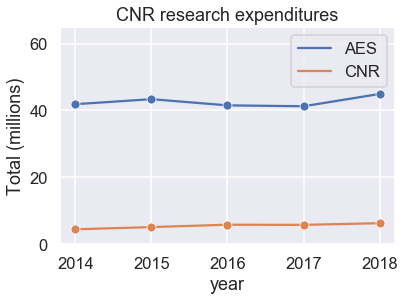

In [9]:
ax = sns.lineplot(x = 'year',
             y = 'total',
             hue = 'unit',
             marker = 'o',
             data = UCBdata.loc[(UCBdata.loc[:,'category']=='research')&idx_CNR_AES,:]);
ax.set(ylabel='Total (millions)')
ax.set_title('CNR research expenditures')
plt.ylim(0, 65)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.ticklabel_format(style='plain', axis='y')
# now do a backflip to get rid of the legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:]);

### Salaries vs other expenditures
Look at salaries vs other expenditures

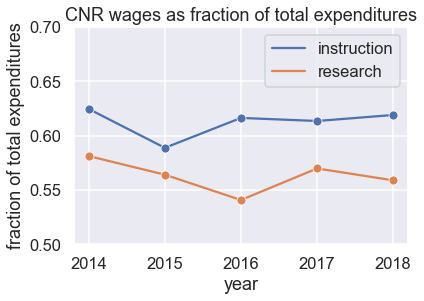

In [10]:
grouped_CNRAES_InstRes['wage_ratio'] = grouped_CNRAES_InstRes['salaries_wages']/grouped_CNRAES_InstRes['total']
sns.set()
sns.set_context("talk")
ax = sns.lineplot(x = 'year',
             y = 'wage_ratio',
             hue = 'category',
             marker = 'o',
             data = grouped_CNRAES_InstRes);
ax.set(ylabel='fraction of total expenditures')
plt.ylim(0.5, 0.7)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.ticklabel_format(style='plain', axis='y')
ax.set_title('CNR wages as fraction of total expenditures');
# now do a backflip to get rid of the legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:]);

### Dean's office spending
Let's start looking at dean's office expenditures

In [11]:
idx_dean = (UCBdata.loc[:,'category']=='instruction_dean')|(UCBdata.loc[:,'category']=='research_dean')

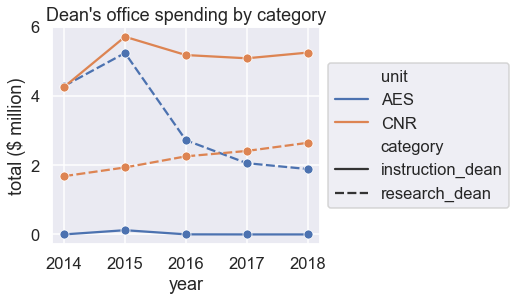

In [12]:
ax = sns.lineplot(x = 'year',
             y = 'total',
             hue = 'unit',
             style = 'category',
             marker = 'o',
             data = UCBdata.loc[idx_dean&idx_CNR_AES,:]);

ax.set(ylabel='total ($ million)')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.ticklabel_format(style='plain', axis='y')
ax.set_title('Dean\'s office spending by category');

# shrink plot width to make room for legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Some comments here.
* I believe that the instruction spending is predominantly TAS, but this needs to be checked.
* I believe that research spending within CNR is startup and retention spending, but this needs to be checked.
* I believe that research / AES spending is predominantly extension.  But this needs to be checked.
* I don't know why AES research spending has fallen so much in the last three years.

### CNR vs other units

### Central campus spending

First create and index array with all institutional support categories

In [ ]:
idx_InstSup = UCBdata.loc[:,'unit'] == 'InstSupport'

In [23]:
UCBdata.loc[idx_InstSup,'category'].unique()

array(['total', 'contracts_grants', 'shared_services'], dtype=object)

Text(0.5,1,'Central campus spending')

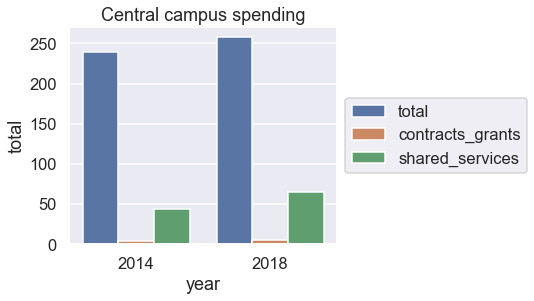

In [54]:
ax = sns.barplot(x = 'year',
             y = 'total',
             hue = 'category',
             data = UCBdata.loc[idx_InstSup,:]);

# shrink plot width to make room for legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

ax.set_title('Central campus spending')

## unintelligible stuff past here

Create a new set of rows measuring InstSupport spending *other* than shared services

In [52]:
years = UCBdata.loc[:,'year'].unique()
for yr in years:
    idxIStot = (UCBdata.loc[:,'year']== yr)&\
        (UCBdata.loc[:,'unit']=='InstSupport')&\
        (UCBdata.loc[:,'category']=='total')
    idxISSS = (UCBdata.loc[:,'year']== yr)&\
        (UCBdata.loc[:,'unit']=='InstSupport')&\
        (UCBdata.loc[:,'category']=='shared_services')
    #diff = (UCBdata.loc[idxIStot,'total'][1]) - (UCBdata.loc[idxISSS,'total'][1])
    print(UCBdata.loc[(UCBdata.loc[:,'year']== yr)&\
        (UCBdata.loc[:,'unit']=='InstSupport')&\
        (UCBdata.loc[:,'category']=='total'),'total'] 
          - UCBdata.loc[(UCBdata.loc[:,'year']== yr)&\
        (UCBdata.loc[:,'unit']=='InstSupport')&\
        (UCBdata.loc[:,'category']=='shared_services'),'total'])

12   NaN
30   NaN
Name: total, dtype: float64
Series([], Name: total, dtype: float64)
Series([], Name: total, dtype: float64)
Series([], Name: total, dtype: float64)
81   NaN
99   NaN
Name: total, dtype: float64
